In [19]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b

In [20]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,1,1)

In [21]:
market = Market()
speculation_db = ADatabase("forex_experimental")

In [22]:
speculation_db.connect()
t = speculation_db.retrieve("trades")
speculation_db.disconnect()

In [23]:
reqs = [0.05,0.1,0.15]
signals = [0.05,0.1,0.15]
values = [True,False]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [True,False]
parameters = []
positions = 10
training_year = 4
for value in values:
    for classification in classifications:
        for ceiling in ceilings:
            for floor in floors:
                for hedge in hedges:
                    for signal in signals:
                        for req in reqs:
                            parameter = {"value":value
                                         ,"classification":classification
                                         ,"ceiling":ceiling
                                         ,"floor":floor
                                         ,"hedge":hedge
                                         ,"signal":signal
                                         ,"req":req
                                         ,"training_years":training_year}
                            parameters.append(parameter)

In [24]:
analysis = []
for parameter in parameters:
    for position in range(positions):
        position_trades = t[(t["position"]==position)].sort_values(["year","week"])
        for key in parameter.keys():
            position_trades = position_trades[position_trades[key]==parameter[key]]
        initial = 100 / positions
        for delta in position_trades["actual_returns"]:
            initial = initial * delta
        if position_trades.index.size > 0:
            wr = position_trades[position_trades["actual_returns"]>0].index.size / position_trades.index.size
            analysis_dict = {}
            for key in parameter.keys():
                analysis_dict[key] = parameter[key]
            analysis_dict["position"]=position
            analysis_dict["wr"]=wr
            analysis_dict["pv"]=initial
            analysis.append(analysis_dict)
a = pd.DataFrame(analysis)

In [25]:
a

,value,classification,ceiling,floor,hedge,signal,req,training_years,position,wr,pv
0,True,True,True,True,True,0.05,0.15,4,0,1.0,2.671925
1,True,True,True,True,True,0.05,0.15,4,1,1.0,2.831202
2,True,True,True,True,True,0.05,0.15,4,2,1.0,6.046857
3,True,True,True,True,True,0.05,0.15,4,3,1.0,6.824066
4,True,True,True,True,True,0.05,0.15,4,4,1.0,5.339351
...,...,...,...,...,...,...,...,...,...,...,...
635,False,False,False,False,False,0.10,0.15,4,5,1.0,10.267332
636,False,False,False,False,False,0.10,0.15,4,6,1.0,10.479774
637,False,False,False,False,False,0.10,0.15,4,7,1.0,12.133171
638,False,False,False,False,False,0.10,0.15,4,8,1.0,12.395483


In [26]:
indexer = list(parameters[0].keys())
complete = a.pivot_table(index=indexer,columns="position",values="pv",fill_value=100/positions).reset_index()
complete["pv"] = [sum([row[1][i] for i in range(positions)]) for row in complete.iterrows()]
complete[indexer + ["pv"]].sort_values("pv",ascending=False)

position,value,classification,ceiling,floor,hedge,signal,req,training_years,pv
53,True,True,False,True,False,0.10,0.15,4,114.827429
52,True,True,False,True,False,0.05,0.15,4,114.827429
49,True,True,False,False,False,0.10,0.15,4,112.015261
48,True,True,False,False,False,0.05,0.15,4,112.015261
28,False,True,True,True,False,0.05,0.15,4,107.558292
...,...,...,...,...,...,...,...,...,...
42,True,False,True,False,True,0.05,0.15,4,55.295478
7,False,False,False,True,True,0.10,0.15,4,51.877243
6,False,False,False,True,True,0.05,0.15,4,51.877243
3,False,False,False,False,True,0.10,0.15,4,46.366140


In [27]:
top = complete.sort_values("pv",ascending=False).iloc[0]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]

In [28]:
ledger.sort_values(["year","week","delta"]).head(30)

,year,week,ticker,delta,actual_returns,position
12257,2020,2,BAM,1.156096,1.007715,9
12154,2020,2,CHF,1.227606,1.004034,8
12051,2020,2,PEN,1.275177,1.002711,7
11948,2020,2,LYD,1.331767,0.999106,6
11845,2020,2,TJS,1.793691,0.998915,5
11742,2020,2,MAD,1.828475,0.999349,4
11639,2020,2,SEK,1.923985,1.003563,3
11536,2020,2,BHD,2.318856,0.999873,2
11433,2020,2,CLF,11.528698,1.004801,1
11330,2020,2,BTC,2169.700241,1.016393,0


In [29]:
ledger

,year,week,ticker,delta,actual_returns,position
11330,2020,2,BTC,2169.700241,1.016393,0
11331,2020,3,BTC,2275.560275,0.991150,0
11332,2020,4,XAU,575.239695,0.992212,0
11333,2020,5,BTC,2499.084315,1.009434,0
11334,2020,6,CLF,11.330039,1.013413,0
...,...,...,...,...,...,...
12355,2021,48,BND,1.028681,1.001435,9
12356,2021,49,PGK,1.181884,1.000015,9
12357,2021,50,EUR,1.313805,1.001728,9
12358,2021,51,NOK,0.815613,0.989386,9


In [30]:
metric = "position"

In [31]:
portfolio = ledger.pivot_table(index=["year","week"],columns=metric,values="actual_returns").fillna(1).reset_index()

In [32]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = pd.read_csv("./csv_files/prices/UUP.csv")
bench = p.column_date_processing(bench)
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,1.016393,1.004801,0.999873,1.003563,0.999349,0.998915,0.999106,1.002711,1.004034,1.007715,2020-W2,2020-01-06,1.003646,25.991236,1.000000
1,1.007399,1.010312,1.009494,1.003133,0.999243,0.998837,0.998851,1.008452,1.005912,1.007913,2020-W3,2020-01-13,1.004955,26.090363,1.003814
2,0.999553,1.010312,1.009873,1.003256,0.999598,1.002374,0.999111,1.006213,1.003678,1.005675,2020-W4,2020-01-20,1.003964,26.159752,1.006484
3,1.008983,1.029082,1.014050,1.003391,1.002069,0.996892,1.008802,1.016714,0.989855,0.991824,2020-W5,2020-01-27,1.006166,26.050713,1.002288
4,1.022517,1.023429,1.013746,1.003219,1.006475,1.004639,1.008430,1.026253,1.000828,1.002819,2020-W6,2020-02-03,1.011236,26.427397,1.016781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,1.524703,1.000017,1.056977,1.261827,0.936360,1.045622,1.169242,1.205348,1.121790,1.190520,2021-W48,2021-11-29,1.151241,25.545162,0.982838
99,1.635304,1.005010,1.056380,1.261221,0.942273,1.045054,1.168619,1.204738,1.121797,1.190538,2021-W49,2021-12-06,1.163093,25.525335,0.982075
100,1.606063,1.005289,1.057078,1.260775,0.941940,1.044708,1.168180,1.205055,1.117936,1.192595,2021-W50,2021-12-13,1.159962,25.683941,0.988177
101,1.594472,0.996559,1.056205,1.250067,0.942089,1.044647,1.167701,1.208529,1.062039,1.179937,2021-W51,2021-12-20,1.150224,25.505510,0.981312


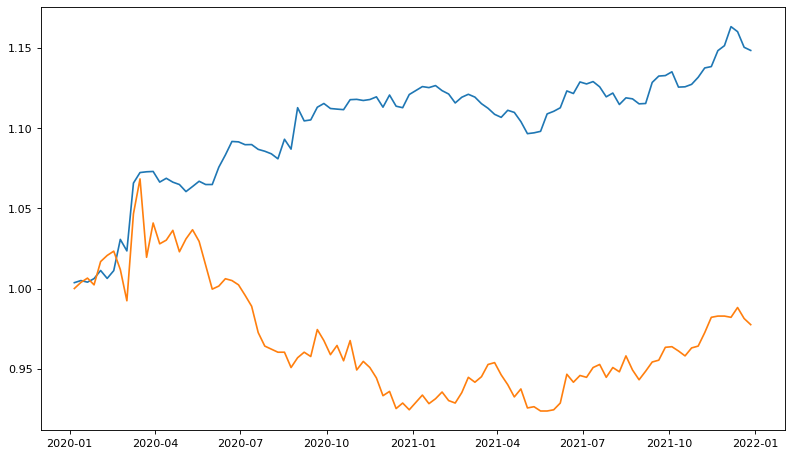

In [33]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])

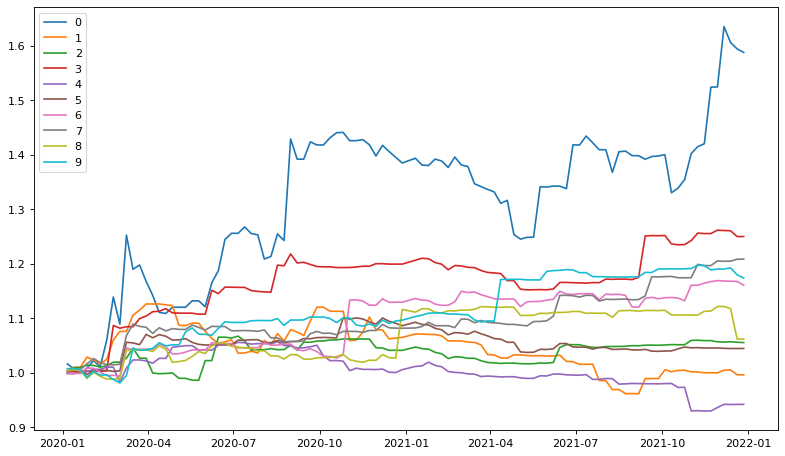

In [34]:
plt.figure(figsize=(12, 7), dpi=80)
for i in counted_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
    plt.legend(counted_columns)
plt.show()
